# 1. **Setup**

In [1]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 7.0 MB/s 
     |████████████████████████████████| 895 kB 65.2 MB/s 
     |████████████████████████████████| 3.3 MB 51.1 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 596 kB 77.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. **Imports**

In [45]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from sklearn.model_selection import train_test_split

import tensorflow as tf
import pandas as pd
import re
import copy
import numpy as np
import os

import seaborn as sns
import matplotlib
matplotlib.style.use('seaborn-darkgrid')
import matplotlib.pyplot as plt

PATH = "/content/drive/My Drive/NN-NLP/"

# 3. **Hyperparameters**

In [4]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"

MAX_LENGTH = 128
BATCH_SIZE = 32
SHUFFLE_SIZE = 1000
PRETRAIN_STEPS = 2
PRETRAIN_LEARNING_RATE = 5e-5
TRAIN_STEPS = 4
TRAIN_LEARNING_RATE = 2e-5

# 4. **Upload Dataset**

In [5]:
df = pd.read_csv("/content/drive/My Drive/NN-NLP/IMDB Dataset.csv")

In [6]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# 5. **Preprocessing Reviews**

In [7]:
preprocessed_df = copy.deepcopy(df)
preprocessed_df['review'] = preprocessed_df['review'].apply(lambda review: re.sub('<[^<]+?>', '', str(review)))
preprocessed_df['sentiment'] = preprocessed_df['sentiment'].replace('positive', 1)
preprocessed_df['sentiment'] = preprocessed_df['sentiment'].replace('negative', 0)

In [8]:
preprocessed_df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. The filming tec...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [9]:
train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(preprocessed_df['review'].to_numpy(),
                                                                                  preprocessed_df['sentiment'].to_numpy(),
                                                                                  test_size=0.5)

indexes_validation = np.random.choice(test_reviews.shape[0], int(test_reviews.shape[0] * 0.2), replace=False)
validation_reviews = test_reviews[indexes_validation]
validation_sentiments = test_sentiments[indexes_validation]

In [10]:
print(train_reviews.shape)
print(validation_reviews.shape)
print(test_reviews.shape)

(25000,)
(5000,)
(25000,)


In [11]:
train_df = pd.DataFrame(np.array([train_reviews, train_sentiments]).T, columns=['review', 'sentiment'])
validation_df = pd.DataFrame(np.array([validation_reviews, validation_sentiments]).T, columns=['review', 'sentiment'])
test_df = pd.DataFrame(np.array([test_reviews, test_sentiments]).T, columns=['review', 'sentiment'])

In [12]:
train_df

,review,sentiment
0,Some spoilers If you are a big horror movie fa...,1
1,BEING Warner Brothers' second historical drama...,1
2,A refreshing interview with the legendary Ital...,1
3,Opening credits: great. Music: just right for ...,1
4,"Alan Alda plays real-life ""Sports Illustrated""...",0
...,...,...
24995,"On one Thursday evening at 10:00pm, my local w...",0
24996,"I have to admit, I wasn't expecting much going...",1
24997,"A journey of discovery, this film follows the ...",1
24998,How to Lose Friends & Alienate People is in al...,1


In [13]:
def convert_data_to_input_examples(data_df, text_col, label_col):
    data_input_examples = data_df.apply(lambda data_review: InputExample(guid='', text_a=data_review[text_col],
                                                                         text_b=None, label=data_review[label_col]), axis=1)

    return data_input_examples

In [14]:
train_input_examples = convert_data_to_input_examples(data_df=train_df, text_col='review', label_col='sentiment')
validation_input_examples = convert_data_to_input_examples(data_df=validation_df, text_col='review', label_col='sentiment')
test_input_examples = convert_data_to_input_examples(data_df=test_df, text_col='review', label_col='sentiment')

In [15]:
train_input_examples

0        InputExample(guid='', text_a="Some spoilers If...
1        InputExample(guid='', text_a='BEING Warner Bro...
2        InputExample(guid='', text_a="A refreshing int...
3        InputExample(guid='', text_a='Opening credits:...
4        InputExample(guid='', text_a='Alan Alda plays ...
                               ...                        
24995    InputExample(guid='', text_a='On one Thursday ...
24996    InputExample(guid='', text_a="I have to admit,...
24997    InputExample(guid='', text_a='A journey of dis...
24998    InputExample(guid='', text_a='How to Lose Frie...
24999    InputExample(guid='', text_a='DRACULA 2000 is ...
Length: 25000, dtype: object

# 6. **Tokenization & Input Formatting**

In [16]:
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [17]:
def convert_input_examples_to_tf_dataset(input_examples, tokenizer, max_length=MAX_LENGTH):
    features = []

    for input_example in input_examples:
        input_dict = tokenizer.encode_plus(text=input_example.text_a,
                                           add_special_tokens=True,
                                           padding='max_length',
                                           max_length=max_length,
                                           truncation=True,
                                           return_token_type_ids=True,
                                           return_attention_mask=True)

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
                                                     input_dict["token_type_ids"], input_dict['attention_mask'])

        input_feature = InputFeatures(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                                      label=input_example.label)
        features.append(input_feature)

    def gen():
       for feature in features:
           yield ({"input_ids": feature.input_ids, "attention_mask": feature.attention_mask,
                  "token_type_ids": feature.token_type_ids}, feature.label)
    
    return tf.data.Dataset.from_generator(gen,
                                         ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32},
                                          tf.int64),
                                         ({"input_ids": tf.TensorShape([None]), "attention_mask": tf.TensorShape([None]),
                                           "token_type_ids": tf.TensorShape([None])}, tf.TensorShape([])))

In [18]:
train_tf_dataset = convert_input_examples_to_tf_dataset(train_input_examples.to_numpy(), tokenizer)
validation_tf_dataset = convert_input_examples_to_tf_dataset(validation_input_examples.to_numpy(), tokenizer)
test_tf_dataset = convert_input_examples_to_tf_dataset(test_input_examples.to_numpy(), tokenizer)

In [19]:
print(train_tf_dataset)
print(validation_tf_dataset)
print(test_tf_dataset)

<FlatMapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>
<FlatMapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>
<FlatMapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>


In [20]:
tf.data.experimental.save(train_tf_dataset, os.path.join(PATH, "train_bert"))
tf.data.experimental.save(validation_tf_dataset, os.path.join(PATH, "validation_bert"))
tf.data.experimental.save(test_tf_dataset, os.path.join(PATH, "test_bert"))

In [21]:
train_tf = tf.data.experimental.load(os.path.join(PATH, "train_bert"))
validation_tf = tf.data.experimental.load(os.path.join(PATH, "validation_bert"))
test_tf = tf.data.experimental.load(os.path.join(PATH, "test_bert"))

train_tf = train_tf.shuffle(SHUFFLE_SIZE, reshuffle_each_iteration=True).batch(BATCH_SIZE)
validation_tf = validation_tf.batch(BATCH_SIZE)
test_tf = test_tf.batch(BATCH_SIZE)

In [22]:
print(train_tf)
print(validation_tf)
print(test_tf)

<BatchDataset shapes: ({attention_mask: (None, None), token_type_ids: (None, None), input_ids: (None, None)}, (None,)), types: ({attention_mask: tf.int32, token_type_ids: tf.int32, input_ids: tf.int32}, tf.int64)>
<BatchDataset shapes: ({token_type_ids: (None, None), attention_mask: (None, None), input_ids: (None, None)}, (None,)), types: ({token_type_ids: tf.int32, attention_mask: tf.int32, input_ids: tf.int32}, tf.int64)>
<BatchDataset shapes: ({token_type_ids: (None, None), attention_mask: (None, None), input_ids: (None, None)}, (None,)), types: ({token_type_ids: tf.int32, attention_mask: tf.int32, input_ids: tf.int32}, tf.int64)>


# 7. **BERT**

In [23]:
model = TFBertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


# 8. **Pre-training BERT**

In [25]:
freezed_layers_names = [
                         # "bert", 
                         "dropout_37", 
                         "classifier"
                       ]

for layer in model.layers:
  
  if layer.name in freezed_layers_names:
      layer.trainable = False

      for w in layer.weights: 
          w._trainable = False
  else:
        layer.trainable = True

        for w in layer.weights: 
          w._trainable = True

In [26]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [27]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,482,240
Non-trainable params: 1,538
_________________________________________________________________


In [28]:
class SlantedTriangularScheduler(tf.keras.callbacks.Callback):
    
    def __init__(self, lr_max=PRETRAIN_LEARNING_RATE, cut_frac=0.1, ratio=32):
        self.lr_max = lr_max
        self.cut_frac = cut_frac
        self.ratio = ratio
    
    def on_train_begin(self, logs=None):
        epochs = self.params['epochs']
        steps = self.params['steps']
        self.cut = epochs * steps * self.cut_frac
        self.iteration = 0
        
    def on_batch_begin(self, batch, logs=None):
        iter = self.iteration
        cut = self.cut
        if iter < cut:
            p = iter / cut
        else:
            p = 1 - (iter - cut) / (cut * (1 / self.cut_frac - 1))
        lr = self.lr_max * (1 + p * (self.ratio - 1)) / self.ratio
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.iteration += 1

In [29]:
model_callbacks = [SlantedTriangularScheduler()]
with tf.device('/device:GPU:0'):
    model.fit(train_tf,
              validation_data=validation_tf, 
              epochs=PRETRAIN_STEPS,   
              verbose=1,
              callbacks=model_callbacks)

Epoch 1/2
782/782 [==============================] - 715s 885ms/step - loss: 0.3501 - accuracy: 0.8435 - val_loss: 0.2873 - val_accuracy: 0.8796
Epoch 2/2
782/782 [==============================] - 692s 884ms/step - loss: 0.1634 - accuracy: 0.9372 - val_loss: 0.3178 - val_accuracy: 0.8930


# 9. **Fine-tunning BERT**

In [30]:
freezed_layers_names = [
                         "bert", 
                         # "dropout_37", 
                         # "classifier"
                       ]

for layer in model.layers:
  
  if layer.name in freezed_layers_names:
      layer.trainable = False

      for w in layer.weights: 
          w._trainable = False
  else:
        layer.trainable = True

        for w in layer.weights: 
          w._trainable = True

In [31]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [32]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 1,538
Non-trainable params: 109,482,240
_________________________________________________________________


In [33]:
class SlantedTriangularScheduler(tf.keras.callbacks.Callback):
    
    def __init__(self, lr_max=TRAIN_LEARNING_RATE, cut_frac=0.1, ratio=32):
        self.lr_max = lr_max
        self.cut_frac = cut_frac
        self.ratio = ratio
    
    def on_train_begin(self, logs=None):
        epochs = self.params['epochs']
        steps = self.params['steps']
        self.cut = epochs * steps * self.cut_frac
        self.iteration = 0
        
    def on_batch_begin(self, batch, logs=None):
        iter = self.iteration
        cut = self.cut
        if iter < cut:
            p = iter / cut
        else:
            p = 1 - (iter - cut) / (cut * (1 / self.cut_frac - 1))
        lr = self.lr_max * (1 + p * (self.ratio - 1)) / self.ratio
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        self.iteration += 1

In [34]:
checkpoint_path = os.path.join(PATH, "BERT Best Model", "bert")

save_best_model_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(PATH, checkpoint_path),
                                                              save_weights_only=True,
                                                              monitor='val_accuracy',
                                                              mode='max',
                                                              save_best_only=True)

In [36]:
history = tf.keras.callbacks.History()
model_callbacks = [SlantedTriangularScheduler(), save_best_model_callback, history]

with tf.device('/device:GPU:0'):
    model.fit(train_tf, 
              validation_data=validation_tf,
              epochs=TRAIN_STEPS, 
              callbacks=model_callbacks)

Epoch 1/4
782/782 [==============================] - 285s 358ms/step - loss: 0.0840 - accuracy: 0.9719 - val_loss: 0.3554 - val_accuracy: 0.8942
Epoch 2/4
782/782 [==============================] - 274s 351ms/step - loss: 0.0835 - accuracy: 0.9722 - val_loss: 0.3624 - val_accuracy: 0.8940
Epoch 3/4
782/782 [==============================] - 276s 353ms/step - loss: 0.0835 - accuracy: 0.9717 - val_loss: 0.3624 - val_accuracy: 0.8944
Epoch 4/4
782/782 [==============================] - 275s 351ms/step - loss: 0.0843 - accuracy: 0.9712 - val_loss: 0.3614 - val_accuracy: 0.8940


In [37]:
np.save(os.path.join(PATH, 'BERT Model History.npy'), history.history)

# 10. **Evaluate model**

In [38]:
model.load_weights(os.path.join(PATH, "BERT Best Model", "bert"))

In [40]:
with tf.device('/device:GPU:0'):
    test_loss, test_acc = model.evaluate(test_tf)
  
    print('Test Loss: %.5f' % test_loss)
    print('Test Accuracy: %.5f' % test_acc)

782/782 [==============================] - 217s 277ms/step - loss: 0.3612 - accuracy: 0.8944
Test Loss: 0.36119
Test Accuracy: 0.89444


# 11. **Plot Loss & Accuracy**

In [41]:
history = np.load(os.path.join(PATH, 'BERT Model History.npy'), allow_pickle='TRUE').item()

In [42]:
print(history)

{'loss': [0.08404847979545593, 0.08346828818321228, 0.0834546759724617, 0.08428002893924713], 'accuracy': [0.9719200134277344, 0.9721599817276001, 0.9717199802398682, 0.9712399840354919], 'val_loss': [0.3553905487060547, 0.36241477727890015, 0.36242255568504333, 0.3613845109939575], 'val_accuracy': [0.8942000269889832, 0.8939999938011169, 0.8944000005722046, 0.8939999938011169]}


In [43]:
def create_plot():
    train_losses = history.get('loss')
    train_accuracies = history.get('accuracy')
    validation_losses = history.get('val_loss')
    validation_accuracies = history.get('val_accuracy')
    title_plot = "Training Analysis - BERT Model"

    figure, axs = plt.subplots(1, 2, figsize=(12, 7))

########################################################################################################################
# First plot #

    ax1 = axs[0]
    line_1 = ax1.plot(np.arange(len(train_losses)), train_losses, color='orange', linewidth=2, marker='o', label="Train Loss")

    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Loss', fontsize=15)

    ax1.set_xticks(np.around(np.arange(0, len(train_losses), step=1)))

    line_2 = ax1.plot(np.arange(len(validation_losses)), validation_losses, color='blue', linewidth=2, marker='s', label="Validation Loss")

    lines_second_plot = line_1 + line_2
    labels_lines_first_plot = [line.get_label() for line in lines_second_plot]

    ax1.legend(lines_second_plot, labels_lines_first_plot, loc=0, frameon=True, fontsize=14)
    ax1.set_title("Loss Comparison", fontsize=17)

    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

########################################################################################################################
# Second plot #

    ax2 = axs[1]
    line_3 = ax2.plot(np.arange(len(train_accuracies)), train_accuracies, color='orange', linewidth=2, marker='o', label="Train Accuracy")

    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Accuracy', fontsize=15)

    ax2.set_xticks(np.around(np.arange(0, len(train_accuracies), step=1)))

    line_4 = ax2.plot(np.arange(len(validation_accuracies)), validation_accuracies, color='blue', linewidth=2,  marker='s', label="Validation Accuracy")

    lines_second_plot = line_3 + line_4
    labels_lines_second_plot = [line.get_label() for line in lines_second_plot]

    ax2.legend(lines_second_plot, labels_lines_second_plot, loc=0, frameon=True, fontsize=14)
    ax2.set_title("Accuracy Comparison", fontsize=17)

    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(title_plot, fontsize=20)
    plt.savefig(os.path.join(PATH, "Model BERT Plot.png"))
    #plt.show()

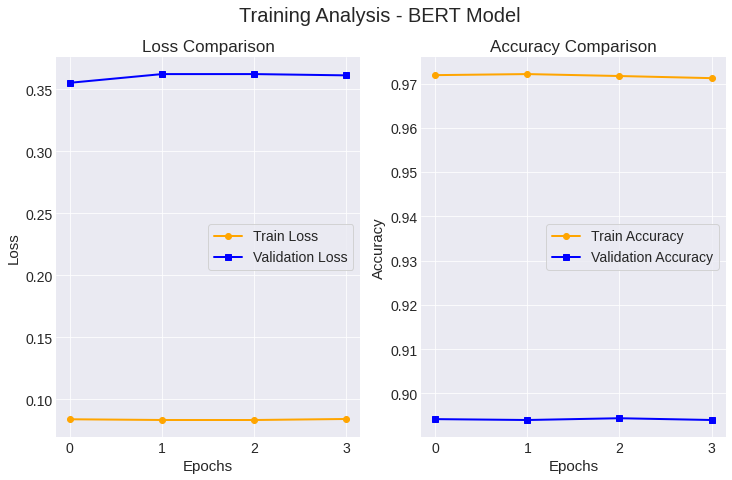

In [46]:
create_plot()